<a href="https://colab.research.google.com/github/peacemakafui/Msc-Advanced-Computation-midsem-project/blob/main/Agricultural_Data_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
import numpy as np

# Generate synthetic data
np.random.seed(42)
n_samples = 100000
data = {
    'Soil_Moisture': np.random.randint(20, 70, n_samples),  # Soil moisture in %
    'Rainfall': np.random.randint(0, 20, n_samples),        # Rainfall in mm
    'Temperature': np.random.randint(20, 35, n_samples),    # Temperature in °C
    'Humidity': np.random.randint(50, 80, n_samples),       # Humidity in %
    'Crop_Type': np.random.choice(['Wheat', 'Maize', 'Rice'], n_samples),  # Crop type
    'Irrigation_Needed': np.random.randint(0, 2, n_samples)  # 0 = No, 1 = Yes
}

# Convert to DataFrame
df = pd.DataFrame(data)
print(df.head())

   Soil_Moisture  Rainfall  Temperature  Humidity Crop_Type  Irrigation_Needed
0             58        15           25        53     Wheat                  1
1             48         3           26        54     Wheat                  1
2             34        19           32        57      Rice                  1
3             62         2           29        72     Wheat                  1
4             27         4           28        57      Rice                  0


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

# Encode Crop_Type (convert categorical data to numerical)

df['Crop_Type'] = df['Crop_Type'].map({'Maize': 0, 'Wheat': 1, 'Rice': 2})

# Features (X) and Target (y)
X = df[['Soil_Moisture', 'Rainfall', 'Temperature', 'Humidity', 'Crop_Type']]
y = df['Irrigation_Needed']
print(X.head())


   Soil_Moisture  Rainfall  Temperature  Humidity  Crop_Type
0             58        15           25        53          1
1             48         3           26        54          1
2             34        19           32        57          2
3             62         2           29        72          1
4             27         4           28        57          2


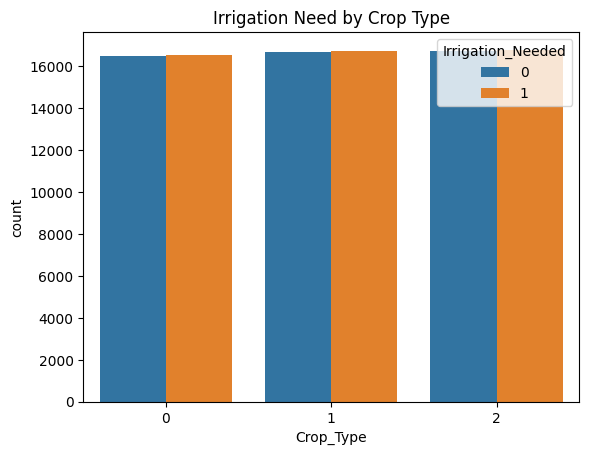

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns  # Import seaborn for better visualization

# Scatter plot for Soil_Moisture vs. Irrigation_Needed
sns.countplot(x='Crop_Type', hue='Irrigation_Needed', data=df)
plt.title('Irrigation Need by Crop Type')
plt.show()

In [5]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Decision Tree Classifier
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy * 100:.2f}%")
print("Classification Report:")
print(classification_report(y_test, y_pred))


Model Accuracy: 50.22%
Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.51      0.50     10004
           1       0.50      0.50      0.50      9996

    accuracy                           0.50     20000
   macro avg       0.50      0.50      0.50     20000
weighted avg       0.50      0.50      0.50     20000



In [1]:
param_grid = {# for randomforest
       'n_estimators': [100, 200, 300],
       'max_depth': [None, 10, 20],
       # ... other hyperparameters
   }
# # param_grid = {
# #     'C': [0.1, 1, 10, 100],
# #     'kernel': ['linear', 'rbf', 'poly'],
# #     'gamma': ['scale', 'auto', 0.1, 1, 10],
# #     'degree': [2, 3, 4],  # Only for 'poly' kernel
# # }
# grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)
# grid_search.fit(X_train, y_train)
# best_model = grid_search.best_estimator_

In [22]:

# Function to provide irrigation recommendation and insights
def irrigation_recommendation(soil_moisture, rainfall, temperature, humidity, crop_type):
    # Map crop type to numerical value
    crop_mapping = {'Maize': 0, 'Wheat': 1, 'Rice': 2}
    crop_type_encoded = crop_mapping.get(crop_type, 0)  # Default to Wheat if unknown
    #generalized soil moisture for the used crops

    CROP_MOISTURE_THRESHOLDS = {
    "maize": {"min":50, "max":70},
    "wheat":{"min":40, "max":60},
    "rice": {"min":60, "max":80}
}

    # Create input array
    input_data = np.array([[soil_moisture, rainfall, temperature, humidity, crop_type_encoded]])

    # Predict
    prediction = model.predict(input_data)

    # Provide recommendation
    if prediction[0] == 1:
        recommendation = "Irrigation is needed."
    else:
        recommendation = "No irrigation needed."

    # Get minimum threshold across all crop types
    min_threshold_all_crops = min(thresholds["min"] for thresholds in CROP_MOISTURE_THRESHOLDS.values())
    thresholds = CROP_MOISTURE_THRESHOLDS.get(crop_type.lower())
    # Analyze soil moisture trends, considering updated thresholds
    soil_moisture_trend = "stable"
    if soil_moisture < 20:
        soil_moisture_trend = "low (critical)"
    elif soil_moisture < min_threshold_all_crops:  # Check against overall minimum
        soil_moisture_trend = "low"
    elif thresholds:  # Check if thresholds are found for the crop type
        if soil_moisture < thresholds["min"]:
            soil_moisture_trend = "low (critical)"
        elif soil_moisture < thresholds.get("optimal", (thresholds["min"] + thresholds["max"]) / 2):  # Use optimal if available, otherwise calculate midpoint
            soil_moisture_trend = "low"
        elif soil_moisture > thresholds["max"]:
            soil_moisture_trend = "high"
    else:
        soil_moisture_trend = "unknown (crop type not found)"

    # Analyze historical weather patterns
    avg_rainfall = df['Rainfall'].mean()
    rainfall_trend = "below average" if rainfall < avg_rainfall else "above average"

    # Insights
    insights = {
        "Soil Moisture Trend": soil_moisture_trend,
        "Historical Rainfall Trend": rainfall_trend,
        "Average Rainfall (Historical)": f"{avg_rainfall:.2f} mm",
        "Current Rainfall": f"{rainfall} mm",
        "Temperature": f"{temperature} °C",
        "Humidity": f"{humidity}%",
        "Crop Type": crop_type
    }

    return recommendation, insights

# Example Usage
soil_moisture = 30   # Current soil moisture level (%)
rainfall = 15         # Recent rainfall (mm)
temperature =  25    # Current temperature (°C)
humidity = 45      # Current humidity (%)
crop_type = 'Wheat' # Crop type

recommendation, insights = irrigation_recommendation(soil_moisture, rainfall, temperature, humidity, crop_type)

# Output Recommendation and Insights
print("\nIrrigation Recommendation:")
print(recommendation)
print("\nInsights:")
for key, value in insights.items():
    print(f"{key}: {value}")


Irrigation Recommendation:
No irrigation needed.

Insights:
Soil Moisture Trend: low
Historical Rainfall Trend: above average
Average Rainfall (Historical): 9.50 mm
Current Rainfall: 15 mm
Temperature: 25 °C
Humidity: 45%
Crop Type: Wheat


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


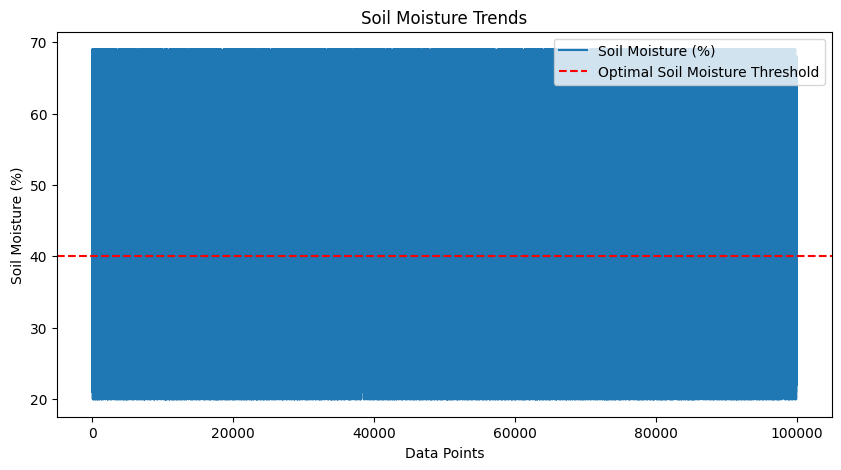

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


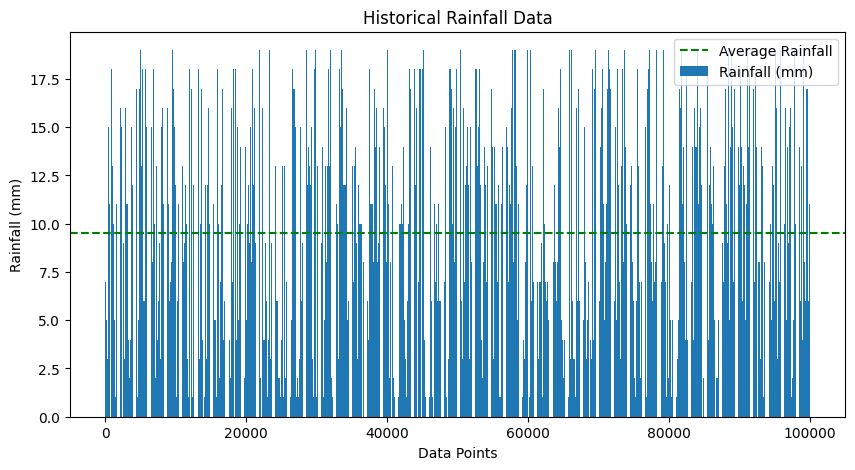

In [23]:
# Visualize Soil Moisture Trends (Example)
plt.figure(figsize=(10, 5))
plt.plot(df['Soil_Moisture'], label='Soil Moisture (%)')
plt.axhline(y=40, color='r', linestyle='--', label='Optimal Soil Moisture Threshold')
plt.title('Soil Moisture Trends')
plt.xlabel('Data Points')
plt.ylabel('Soil Moisture (%)')
plt.legend()
plt.show()

# Visualize Historical Rainfall (Example)
plt.figure(figsize=(10, 5))
plt.bar(df.index, df['Rainfall'], label='Rainfall (mm)')
plt.axhline(y=df['Rainfall'].mean(), color='g', linestyle='--', label='Average Rainfall')
plt.title('Historical Rainfall Data')
plt.xlabel('Data Points')
plt.ylabel('Rainfall (mm)')
plt.legend()
plt.show()